In [2]:
!gdown -q 1LnQ257dpoqot9WvaHzSq9O6ND4aXGyVB

In [3]:
!unzip -q Total.zip -d Total

# Реализация функций, импорты

In [9]:
import matplotlib.pyplot as plt
import os
import numpy as np
import cv2
from glob import glob
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, MaxPooling2D, concatenate, UpSampling2D, Input
from tensorflow.keras.models import Model

In [10]:
# Метрики
import tensorflow as tf
from tensorflow.keras import backend as K

def jaccard_index(y_true, y_pred, smooth=1e-7):
    intersection = K.sum(K.abs(y_true[..., 0] * y_pred[..., 0]), axis=[1, 2])
    union = K.sum(y_true[..., 0], axis=[1, 2]) + K.sum(y_pred[..., 0], axis=[1, 2]) - intersection
    jaccard = (intersection + smooth) / (union + smooth)
    return K.mean(jaccard)

def dice_coefficient(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1, 2, 3])
    return K.mean((2. * intersection + smooth) / (K.sum(y_true, axis=[1, 2, 3]) + K.sum(y_pred, axis=[1, 2, 3]) + smooth), axis=0)

def f1_score(y_true, y_pred, smooth=1):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))

    precision = true_positives / (predicted_positives + smooth)
    recall = true_positives / (possible_positives + smooth)

    return (2 * (precision * recall) / (precision + recall + smooth))

In [11]:
# Unet
def unet(input_size=(200, 200, 1)):
    inputs = Input(input_size)

    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)

    up1 = UpSampling2D(size=(2, 2))(conv2)
    merge1 = concatenate([conv1, up1], axis=3)
    conv3 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge1)
    conv3 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)

    conv4 = Conv2D(1, 1, activation='sigmoid')(conv3)

    model = Model(inputs=inputs, outputs=conv4)

    return model

In [12]:
from PIL import Image

def extract_histogram(path):
    img = Image.open(path).resize((200, 200))
    return np.asarray(img)

In [13]:
path1 = os.listdir('Total/Total/BlackPupilEye/')
path2 = os.listdir('Total/Total/WhitePupilEye/')

In [14]:
X=[]
y=[]

# Загрузка глаз и масок в переменные
for i in range(2):
  for j in range(20):
      for k in range(20):
          label = str(j+1)+'_Left_'+str(k+1)+'.png'
          label_m = str(j+1)+'_Left_'+str(k+1)+'m.png'
          if label in path1 and label_m in path1:
              X.append(extract_histogram('Total/Total/BlackPupilEye/'+label))
              y.append(extract_histogram('Total/Total/BlackPupilEye/'+label_m))


for i in range(2):
    for j in range(20):
        for k in range(20):
            label = str(j+1)+'_Right_'+str(k+1)+'.png'
            label_m = str(j+1)+'_Right_'+str(k+1)+'m.png'
            if label in path1 and label_m in path1:
                X.append(extract_histogram('Total/Total/BlackPupilEye/'+label))
                y.append(extract_histogram('Total/Total/BlackPupilEye/'+label_m))


for i in range(2):
    for j in range(20):
        for k in range(20):
            label = str(j+1)+'_Left_'+str(k+1)+'.png'
            label_m = str(j+1)+'_Left_'+str(k+1)+'m.png'
            if label in path2 and label_m in path2:
                X.append(extract_histogram('Total/Total/WhitePupilEye/'+label))
                y.append(extract_histogram('Total/Total/WhitePupilEye/'+label_m))


for i in range(2):
    for j in range(20):
        for k in range(20):
            label = str(j+1)+'_Right_'+str(k+1)+'.png'
            label_m = str(j+1)+'_Right_'+str(k+1)+'m.png'
            if label in path2 and label_m in path2:
                X.append(extract_histogram('Total/Total/WhitePupilEye/'+label))
                y.append(extract_histogram('Total/Total/WhitePupilEye/'+label_m))

#Обучение на данных без предобработки

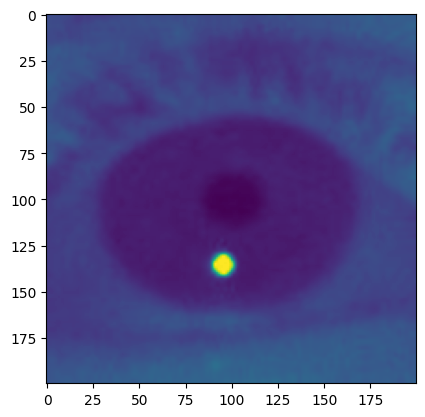

In [7]:
# Пример необработанного изображения глаза
plt.imshow(X[0])

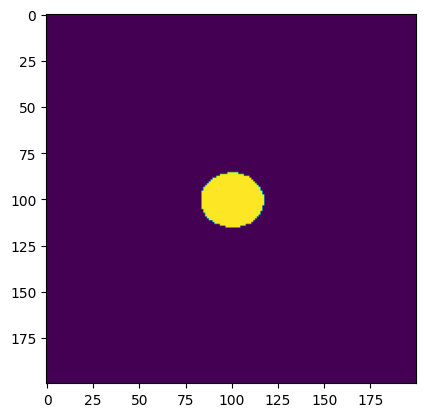

In [8]:
# Пример необработанной маски
plt.imshow(y[0])

In [9]:
# Делим на трейн+вал и тест
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Делим на трейн вал
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [10]:
X_train = np.array(X_train, dtype=np.float32) / 255.0
X_test = np.array(X_test, dtype=np.float32) / 255.0
X_val = np.array(X_val, dtype=np.float32) / 255.0

y_train = np.array(y_train, dtype=np.float32) / 255.0
y_test = np.array(y_test, dtype=np.float32) / 255.0
y_val = np.array(y_val, dtype=np.float32) / 255.0

y_train = np.expand_dims(y_train, axis=-1)
y_test = np.expand_dims(y_test, axis=-1)
y_val = np.expand_dims(y_val, axis=-1)

In [11]:
model = unet()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', jaccard_index, dice_coefficient, f1_score])
model.fit(X_train, y_train, batch_size=16, epochs=40, validation_data=(X_val, y_val))

Epoch 1/40
119/119 [==============================] - 44s 280ms/step - loss: 0.1488 - accuracy: 0.9640 - jaccard_index: 0.1031 - dice_coefficient: 0.1721 - f1_score: 0.0690 - val_loss: 0.0626 - val_accuracy: 0.9756 - val_jaccard_index: 0.2815 - val_dice_coefficient: 0.4192 - val_f1_score: 0.2801
Epoch 2/40
119/119 [==============================] - 27s 226ms/step - loss: 0.0622 - accuracy: 0.9779 - jaccard_index: 0.3180 - dice_coefficient: 0.4578 - f1_score: 0.3373 - val_loss: 0.0689 - val_accuracy: 0.9724 - val_jaccard_index: 0.3356 - val_dice_coefficient: 0.4812 - val_f1_score: 0.3500
Epoch 3/40
119/119 [==============================] - 27s 227ms/step - loss: 0.0564 - accuracy: 0.9797 - jaccard_index: 0.3582 - dice_coefficient: 0.5038 - f1_score: 0.3662 - val_loss: 0.0541 - val_accuracy: 0.9810 - val_jaccard_index: 0.3768 - val_dice_coefficient: 0.5167 - val_f1_score: 0.3596
Epoch 4/40
119/119 [==============================] - 28s 232ms/step - loss: 0.0556 - accuracy: 0.9799 - jacc

In [12]:
y_pred = model.predict(X_test)

19/19 [==============================] - 6s 113ms/step


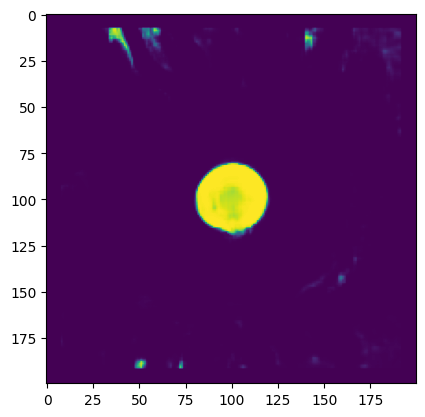

In [13]:
# Пример предсказания по данным без обработки
plt.imshow(y_pred[0])

Много шумов на предикте

In [14]:
jaccard_index_0 = jaccard_index(y_test, y_pred)
dice_coefficient_0 = dice_coefficient(y_test, y_pred)
f1_score_0 = f1_score(y_test, y_pred)

In [15]:
# Метрики
print(jaccard_index_0)
print(dice_coefficient_0)
print(f1_score_0)

tf.Tensor(0.69405633, shape=(), dtype=float32)
tf.Tensor(0.80722356, shape=(), dtype=float32)
tf.Tensor(0.5528829, shape=(), dtype=float32)


# Обучение на аугментированных данных

In [43]:
import imgaug.augmenters as iaa

# Создание последовательности аугментации
augmentation_seq = iaa.Sequential([
    iaa.Fliplr(0.5),  # Горизонтальное отражение с вероятностью 0.5
    iaa.Flipud(0.5),  # Вертикальное отражение с вероятностью 0.5
    iaa.Rotate((-45, 45)),  # Поворот изображений на случайный угол (-45, 45)
    iaa.Affine(scale=(0.8, 1.2)),  # Масштабирование изображений на случайный масштаб (0.8, 1.2)
])

In [44]:
# Делим на трейн+вал и тест
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Делим на трейн вал
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [45]:
masks_3d = [np.expand_dims(mask, axis=2) for mask in y_train]

# Преобразование списка в массив
masks_3d_array = np.array(masks_3d)

In [46]:
# Применение аугментации к обучающим изображениям и маскам
augmented_images, augmented_masks = augmentation_seq(images=X_train, segmentation_maps=masks_3d_array)

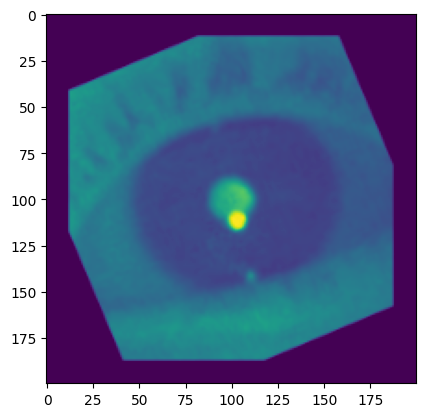

In [47]:
# Пример необработанного изображения глаза
plt.imshow(augmented_images[10])

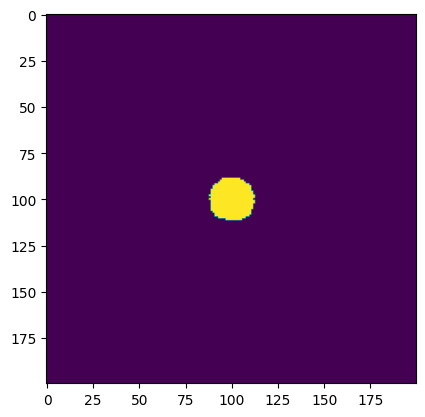

In [48]:
# Пример необработанной маски
plt.imshow(augmented_masks[10])

In [49]:
augmented_images = np.array(augmented_images, dtype=np.float32) / 255.0
X_test = np.array(X_test, dtype=np.float32) / 255.0
X_val = np.array(X_val, dtype=np.float32) / 255.0

augmented_masks = np.array(augmented_masks, dtype=np.float32) / 255.0
y_test = np.array(y_test, dtype=np.float32) / 255.0
y_val = np.array(y_val, dtype=np.float32) / 255.0

y_train = np.expand_dims(y_train, axis=-1)
y_test = np.expand_dims(y_test, axis=-1)
y_val = np.expand_dims(y_val, axis=-1)

In [ ]:
model = unet()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', jaccard_index, dice_coefficient, f1_score])
model.fit(augmented_images, augmented_masks, batch_size=16, epochs=40, validation_data=(X_val, y_val))

Epoch 1/40
119/119 [==============================] - 31s 239ms/step - loss: 0.1289 - accuracy: 0.9687 - jaccard_index: 0.1166 - dice_coefficient: 0.1914 - f1_score: 0.0555 - val_loss: 0.0828 - val_accuracy: 0.9711 - val_jaccard_index: 0.2255 - val_dice_coefficient: 0.3550 - val_f1_score: 0.3050
Epoch 2/40
119/119 [==============================] - 28s 234ms/step - loss: 0.0644 - accuracy: 0.9761 - jaccard_index: 0.2870 - dice_coefficient: 0.4252 - f1_score: 0.3327 - val_loss: 0.0590 - val_accuracy: 0.9777 - val_jaccard_index: 0.3294 - val_dice_coefficient: 0.4766 - val_f1_score: 0.3789
Epoch 3/40
119/119 [==============================] - 27s 227ms/step - loss: 0.0553 - accuracy: 0.9803 - jaccard_index: 0.3567 - dice_coefficient: 0.5004 - f1_score: 0.3851 - val_loss: 0.0622 - val_accuracy: 0.9760 - val_jaccard_index: 0.3770 - val_dice_coefficient: 0.5191 - val_f1_score: 0.3802
Epoch 4/40
119/119 [==============================] - 27s 228ms/step - loss: 0.0522 - accuracy: 0.9814 - jacc

In [24]:
y_pred = model.predict(X_test)

19/19 [==============================] - 2s 121ms/step


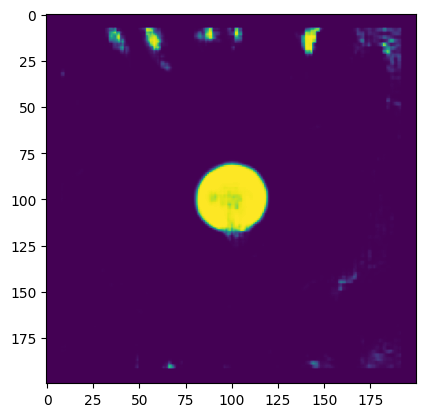

In [25]:
# Пример предсказания по аугментированных данным
plt.imshow(y_pred[0])

Шумов стало даже чуть больше

In [26]:
jaccard_index_1 = jaccard_index(y_test, y_pred)
dice_coefficient_1 = dice_coefficient(y_test, y_pred)
f1_score_1 = f1_score(y_test, y_pred)

In [27]:
# Метрики
print(jaccard_index_1)
print(dice_coefficient_1)
print(f1_score_1)

tf.Tensor(0.6962156, shape=(), dtype=float32)
tf.Tensor(0.8094751, shape=(), dtype=float32)
tf.Tensor(0.5533494, shape=(), dtype=float32)


# Обучение на данных с фильтрацией

In [15]:
filtered_images = []

for image in X:
    # Применение медианного фильтра
    median_filtered = cv2.medianBlur(image, ksize=5)

    # Применение фильтра Гаусса
    gaussian_filtered = cv2.GaussianBlur(median_filtered, (5, 5), sigmaX=0)

    # Добавление отфильтрованного изображения в список
    filtered_images.append(gaussian_filtered)

# Преобразование списка в массив NumPy
filtered_images = np.array(filtered_images)

In [26]:
# Делим на трейн+вал и тест
X_train, X_test, y_train, y_test = train_test_split(filtered_images, y, test_size=0.2, random_state=42)
# Делим на трейн вал
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

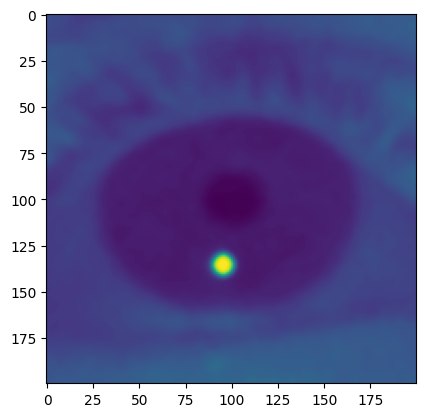

In [17]:
# Пример изобрадения после фильтра Гаусса и медианного фильтра
plt.imshow(filtered_images[0]);

In [27]:
X_train = np.array(X_train, dtype=np.float32) / 255.0
X_test = np.array(X_test, dtype=np.float32) / 255.0
X_val = np.array(X_val, dtype=np.float32) / 255.0

y_train = np.array(y_train, dtype=np.float32) / 255.0
y_test = np.array(y_test, dtype=np.float32) / 255.0
y_val = np.array(y_val, dtype=np.float32) / 255.0

y_train = np.expand_dims(y_train, axis=-1)
y_test = np.expand_dims(y_test, axis=-1)
y_val = np.expand_dims(y_val, axis=-1)

In [28]:
model = unet()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', jaccard_index, dice_coefficient, f1_score])
model.fit(X_train, y_train, batch_size=16, epochs=40, validation_data=(X_val, y_val))

Epoch 1/40
119/119 [==============================] - 49s 274ms/step - loss: 0.1497 - accuracy: 0.9679 - jaccard_index: 0.1059 - dice_coefficient: 0.1759 - f1_score: 0.0858 - val_loss: 0.0644 - val_accuracy: 0.9758 - val_jaccard_index: 0.3170 - val_dice_coefficient: 0.4556 - val_f1_score: 0.3318
Epoch 2/40
119/119 [==============================] - 28s 231ms/step - loss: 0.0686 - accuracy: 0.9760 - jaccard_index: 0.2795 - dice_coefficient: 0.4163 - f1_score: 0.2991 - val_loss: 0.0600 - val_accuracy: 0.9787 - val_jaccard_index: 0.3276 - val_dice_coefficient: 0.4652 - val_f1_score: 0.3243
Epoch 3/40
119/119 [==============================] - 28s 234ms/step - loss: 0.0568 - accuracy: 0.9796 - jaccard_index: 0.3507 - dice_coefficient: 0.4937 - f1_score: 0.3653 - val_loss: 0.0513 - val_accuracy: 0.9809 - val_jaccard_index: 0.3647 - val_dice_coefficient: 0.5055 - val_f1_score: 0.3612
Epoch 4/40
119/119 [==============================] - 28s 234ms/step - loss: 0.0511 - accuracy: 0.9811 - jacc

In [29]:
y_pred = model.predict(X_test)

19/19 [==============================] - 6s 115ms/step


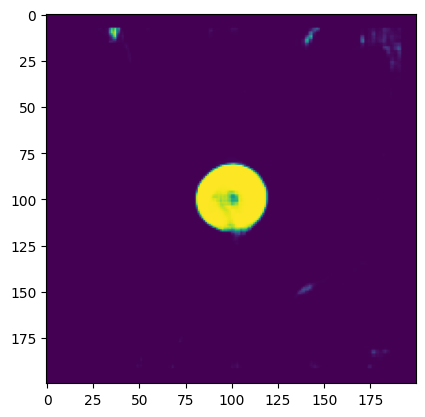

In [30]:
# Пример предсказания по фильтрованым данным
plt.imshow(y_pred[0])

Самый аккуратный предикт среди прочих методов предобработки.

In [31]:
jaccard_index_2 = jaccard_index(y_test, y_pred)
dice_coefficient_2 = dice_coefficient(y_test, y_pred)
f1_score_2 = f1_score(y_test, y_pred)

In [32]:
# Метрики
print(jaccard_index_2)
print(dice_coefficient_2)
print(f1_score_2)

tf.Tensor(0.7822656, shape=(), dtype=float32)
tf.Tensor(0.8697617, shape=(), dtype=float32)
tf.Tensor(0.59030175, shape=(), dtype=float32)


Самые топовые метрики у фильтрации.

# Обучение на данных с измененным контрастом

In [33]:
contrasted_images = []
contrast_factor = 1.5

# Проход по каждому изображению в X_train
for image in X:
    adjusted_image = cv2.convertScaleAbs(image, alpha=contrast_factor, beta=0)

    contrasted_images.append(adjusted_image)
# Преобразование списка в массив numpy
contrasted_images = np.array(contrasted_images)

In [34]:
# Делим на трейн+вал и тест
X_train, X_test, y_train, y_test = train_test_split(contrasted_images, y, test_size=0.2, random_state=42)
# Делим на трейн вал
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

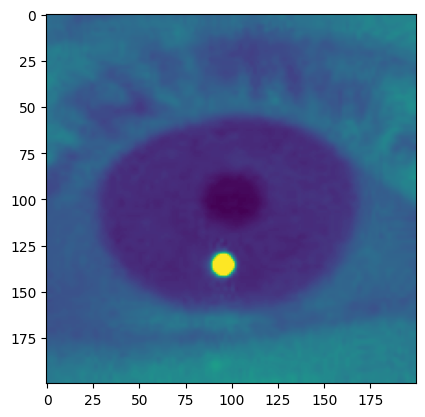

In [35]:
# Пример контрастированного изображения
plt.imshow(contrasted_images[0])

In [36]:
X_train = np.array(X_train, dtype=np.float32) / 255.0
X_test = np.array(X_test, dtype=np.float32) / 255.0
X_val = np.array(X_val, dtype=np.float32) / 255.0

y_train = np.array(y_train, dtype=np.float32) / 255.0
y_test = np.array(y_test, dtype=np.float32) / 255.0
y_val = np.array(y_val, dtype=np.float32) / 255.0

y_train = np.expand_dims(y_train, axis=-1)
y_test = np.expand_dims(y_test, axis=-1)
y_val = np.expand_dims(y_val, axis=-1)

In [37]:
model = unet()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', jaccard_index, dice_coefficient, f1_score])
model.fit(X_train, y_train, batch_size=16, epochs=40, validation_data=(X_val, y_val))

Epoch 1/40
119/119 [==============================] - 31s 237ms/step - loss: 0.1573 - accuracy: 0.9686 - jaccard_index: 0.0728 - dice_coefficient: 0.1265 - f1_score: 0.0373 - val_loss: 0.0723 - val_accuracy: 0.9709 - val_jaccard_index: 0.2140 - val_dice_coefficient: 0.3410 - val_f1_score: 0.2003
Epoch 2/40
119/119 [==============================] - 27s 228ms/step - loss: 0.0748 - accuracy: 0.9736 - jaccard_index: 0.2407 - dice_coefficient: 0.3697 - f1_score: 0.2455 - val_loss: 0.0796 - val_accuracy: 0.9742 - val_jaccard_index: 0.2685 - val_dice_coefficient: 0.4036 - val_f1_score: 0.2437
Epoch 3/40
119/119 [==============================] - 28s 232ms/step - loss: 0.0646 - accuracy: 0.9766 - jaccard_index: 0.3029 - dice_coefficient: 0.4479 - f1_score: 0.3079 - val_loss: 0.0844 - val_accuracy: 0.9756 - val_jaccard_index: 0.2633 - val_dice_coefficient: 0.3994 - val_f1_score: 0.2430
Epoch 4/40
119/119 [==============================] - 27s 227ms/step - loss: 0.0617 - accuracy: 0.9786 - jacc

In [38]:
y_pred = model.predict(X_test)

19/19 [==============================] - 2s 121ms/step


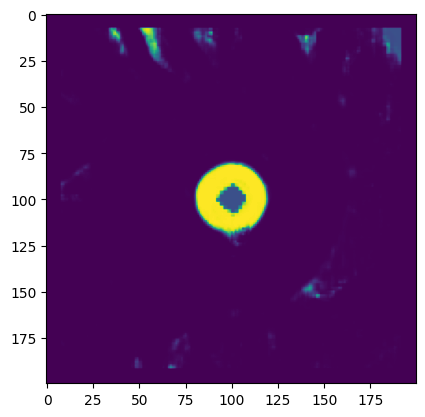

In [39]:
# Пример предсказания по контрастированным данным
plt.imshow(y_pred[0])

Самый грустный результат, можно поиграться с величиной контраста, но обучение длится слишком долго

In [40]:
jaccard_index_3 = jaccard_index(y_test, y_pred)
dice_coefficient_3 = dice_coefficient(y_test, y_pred)
f1_score_3 = f1_score(y_test, y_pred)

In [41]:
# Метрики
print(jaccard_index_3)
print(dice_coefficient_3)
print(f1_score_3)

tf.Tensor(0.66470313, shape=(), dtype=float32)
tf.Tensor(0.7889601, shape=(), dtype=float32)
tf.Tensor(0.53505063, shape=(), dtype=float32)
